In [1]:
# from backend.utils import *
# from backend.ee_retrieval import *
import pandas as pd
from datetime import datetime, timedelta
# import geemap
# import ee
import numpy as np
# from sklearn.linear_model import HuberRegressor
import os
from scipy import interpolate
from scipy.interpolate import griddata
# from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import proplot as pplt
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl

# Code to generate auxiliary files

In [2]:
# load detection dataset
# detdf = pd.read_csv('L5_detections_Jan8_nosmoke.csv')
# load dataset for number of overpass
# freqdf = pd.read_csv('figure_reproduce/frequency.csv')

# figyears = list(range(1986, 2012))
# freqlats = freqdf['Latitude'].values
# freqlons = freqdf['Longitude'].values


# # find unique locations
# subdf = detdf['Longitude'].astype(str) + '_' + detdf['Latitude'].astype(str)
# subdf = set(subdf)
# loclist = np.array([[float(s.split('_')[0]), float(s.split('_')[1])] for s in subdf])
# loclist.shape

# plume_num_df = pd.DataFrame(columns=['Longitude',
#                                      'Latitude'] + list(range(1986, 2012))                           
#                            )   # Number of plumes

# cf_num_df = pd.DataFrame(columns=['Longitude',
#                                      'Latitude'] + list(range(1986, 2012))                           
#                            )   # Number of cloud free stripe free scenes

# cov_adj_df = pd.DataFrame(columns=[ 'Longitude',
#                                      'Latitude'] + list(range(1986, 2012))    
                         
#                          )   # Coverage adjusted number of plumes
# ems_df = pd.DataFrame(columns=[    'Longitude',
#                                      'Latitude'] + list(range(1986, 2012))    
                     
#                      )  # Emission (t)
# ems_err_df = pd.DataFrame(columns=[  'Longitude',
#                                      'Latitude'] + list(range(1986, 2012))    
                         
#                          )  # Emission (t)


In [ ]:
# curr = 0
# for loc in loclist[:]:
#     lonnow = loc[0]
#     latnow = loc[1]

#     distances = np.sqrt((freqlons-lonnow)**2 + (freqlats-latnow)**2)  # find closest location
#     mindex = np.argmin(distances)
  
#     print(distances[mindex])
#     cov_adj = [lonnow, latnow]    # coverage-adjusted number of detections
#     num_plume = [lonnow, latnow]  # number of detected plumes
#     ems_list = [lonnow, latnow]  # annual methane emission
#     ems_uncert_list = [lonnow, latnow]  # uncertainty of the annual methane emission
#     cf_num_list = [lonnow, latnow] # number of cloud-free overpasses
# 
#     for y in figyears:
#         # load number of overpass and number of detections
#         freqsub = freqdf[ (freqdf['Longitude'] == freqlons[mindex]) & (freqdf['Latitude'] == freqlats[mindex]) ]
#         detsub = detdf[(detdf['Longitude'] == lonnow) & (detdf['Latitude'] == latnow) & (detdf['Datetime'].str.contains(str(y)))  ]
#         _num_det = len(detsub)
#         if len(detsub) == 0:
#             _cov_adj_num = 0
#             _num_det = 0
#             anems = 0
#             anems_err = 0
#             if y in range(2003, 2008):
#                 _cf_num = np.nan
#             else:
#                 _cf_num = freqsub[str(y)].values[0]
#         else:
#             _cf_num = freqsub[str(y)].values[0]
#             _freq = min(1, float(_num_det/ _cf_num ))  # fraction of detection/cloud-free overpass
#             if y%4 == 0:
#                 _cov_adj_num = round(366.*_freq)   # coverage-adjusted number of detections
#             else:
#                 _cov_adj_num = round(365.*_freq)

#             _meanQ = np.nanmean(detsub['Q (kg/hr)'].values)  # annual mean flux rates for this location
#             _emeanQ = np.nanstd(detsub['Q (kg/hr)'].values)/np.sqrt( len(detsub[~detsub['Q (kg/hr)'].isna()] ) )   # uncertainty of the annual mean flux
#             if len(detsub[~detsub['Q (kg/hr)'].isna()] ) == 1: # sometimes uncertainty is nan because no repeated detection
#                 _emeanQ = detsub['dQ'].values[0]
#             anems = _meanQ*_cov_adj_num*24*1e-6  # kg/hr to kg to Gg
#             anems_err = _emeanQ*_cov_adj_num*24*1e-6  # kg/hr to kg to Gg
#         cf_num_list.append(_cf_num)
#         cov_adj.append(_cov_adj_num)
#         num_plume.append(_num_det)
#         ems_list.append(anems)
#         ems_uncert_list.append(anems_err)

#     cf_num_df.loc[curr] = cf_num_list
#     cov_adj_df.loc[curr] = cov_adj
#     plume_num_df.loc[curr] = num_plume
#     ems_df.loc[curr] = ems_list
#     ems_err_df.loc[curr] = ems_uncert_list
#     curr += 1
    
# cov_adj_df.to_csv('cov_adj_num.csv', index=False)
# plume_num_df.to_csv('plume_num.csv', index=False)
# ems_df.to_csv('ems.csv', index=False)
# ems_err_df.to_csv('ems_err.csv', index=False)
# cf_num_df.to_csv('cf_num.csv', index=False)     

In [3]:
# load auxiliary data files
cov_adj_df = pd.read_csv('figure_reproduce/cov_adj_num.csv') # coverage adjusted number of detections for each unique location
plume_num_df = pd.read_csv('figure_reproduce/plume_num.csv') # 
ems_df = pd.read_csv('figure_reproduce/ems.csv') # 
ems_err_df = pd.read_csv('figure_reproduce/ems_err.csv')
cf_num_df = pd.read_csv('figure_reproduce/cf_num.csv')   

In [11]:
# load EDGAR bottom up emissions
edgardf = pd.read_csv('figure_reproduce/EDGAR_CH4_1970-2021.csv', skiprows=9, header=1)
turkdf = edgardf[edgardf['Name'] == 'Turkmenistan']
# only select O&G related emission sectors
turkdf = turkdf[(turkdf['ipcc_code_2006_for_standard_report_name'] == 'Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries') |
                (turkdf['ipcc_code_2006_for_standard_report_name'] == 'Oil and Natural Gas')]

# Code to generate combined data sets

In [6]:
# combdf = pd.DataFrame(columns=['Year',
#                                'Num of detections', 
#                                 'Coverage-adjusted', 
#                                 'Dry gas production (Gg/yr)', 
#                                'Dry gas production w/ pre-1992 (Gg/yr)',
#                                'Dry gas production (BCM)', 
#                                'Dry gas production w/ pre-1992 (BCM)',
#                                 'EDGAR O&G Turkmenistan (Gg/yr)', 
#                                 'EDGAR fSU O&G (Gg/yr)', 
#                                 'Annual emissions (Gg/yr)', 
#                                'Annual emissions uncertainty (Gg/yr)', 
#                                 'Leak rate (%)'])
# figyears = list(range(1986, 2012))
# combdf['Year'] = figyears

# edgardf = pd.read_csv('EDGAR_CH4_1970-2021.csv', skiprows=9, header=1)
# turkdf = edgardf[edgardf['Name'] == 'Turkmenistan']
# turkdf = turkdf[(turkdf['ipcc_code_2006_for_standard_report_name'] == 'Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries') |
#                 (turkdf['ipcc_code_2006_for_standard_report_name'] == 'Oil and Natural Gas')]
# bu_turk = np.nansum(turkdf.iloc[:, 24:-10].values, axis=0)
# combdf['EDGAR O&G Turkmenistan (Gg/yr)'] = bu_turk


# df = pd.read_csv('plume_num.csv')
# combdf['Num of detections'] = df.sum()[2:].values
# combdf.replace(0, np.nan, inplace=True)

# df = pd.read_csv('cov_adj_num.csv')
# combdf['Coverage-adjusted'] = df.sum()[2:].values
# combdf.replace(0, np.nan, inplace=True)

# df = pd.read_csv('ems.csv')
# combdf['Annual emissions (Gg/yr)'] = df.sum()[2:].values
# combdf.replace(0, np.nan, inplace=True)

# df = pd.read_csv('ems_err.csv')
# combdf['Annual emissions uncertainty (Gg/yr)'] = df.sum()[2:].values
# combdf.replace(0, np.nan, inplace=True)


# fsu_list = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 
#             'Latvia', 'Lithuania', 'Moldova, Republic of', 'Russian Federation', 'Tajikistan', 
#             'Turkmenistan', 'Ukraine', 'Uzbekistan']
# edgardf = pd.read_excel('v60_CH4_1970_2018.xls', skiprows=9)
# subdf = edgardf[edgardf['Name'].isin(fsu_list)]
# subdf = subdf[(subdf['ipcc_code_2006_for_standard_report_name'] == 'Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries') |
#                 (subdf['ipcc_code_2006_for_standard_report_name'] == 'Oil and Natural Gas')]
# bu_fsu = np.nansum(subdf.iloc[:, 7:].values, axis=0)
# combdf['EDGAR fSU O&G (Gg/yr)'] = bu_fsu[16:-7]


# df = pd.read_csv('SeriesExport-06-22-2023_01-58-59.csv', skiprows=20)
# prodyears = df[df.columns[0]].values
# gasprod= df[df.columns[1]].values
# gasprod = gasprod
# gasprod = list(gasprod)
# _gasprod = [0]*6 + gasprod[:-10]
# combdf['Dry gas production (BCM)'] = _gasprod
# combdf.replace(0, np.nan, inplace=True)

# # bu_scale = bu_turk/np.mean(bu_turk[6:21])  # 1992-1999
# bu_scale = bu_turk/np.mean(bu_turk[6:26])    # 1992--2011
# gasprod_pre92 = np.mean(gasprod[6:26])*bu_scale
# gasprod_comb = np.concatenate([gasprod_pre92[:6], gasprod])[:-10]
# combdf['Dry gas production w/ pre-1992 (BCM)'] = gasprod_comb

# combdf['Dry gas production (Gg/yr)'] = np.array(_gasprod)*1e9*0.712*1e-6  # bcm to m^3 to kg to Gg
# combdf['Dry gas production w/ pre-1992 (Gg/yr)'] = np.array(gasprod_comb)*1e9*0.712*1e-6  # bcm to m^3 to kg to Gg
# combdf.replace(0, np.nan, inplace=True)


# leakrate = combdf['Annual emissions (Gg/yr)']/combdf['Dry gas production w/ pre-1992 (Gg/yr)']*100
# combdf['Leak rate (%)'] = leakrate
# combdf.replace(0, np.nan, inplace=True)
# combdf.replace(np.inf, np.nan, inplace=True)


# # combdf
# combdf.to_csv('combined_data_set.csv', index=False)

In [4]:
combdf = pd.read_csv('figure_reproduce/combined_data_set.csv')
bu_turk = combdf['EDGAR O&G Turkmenistan (Gg/yr)']
gasprod = combdf['Dry gas production (BCM)']

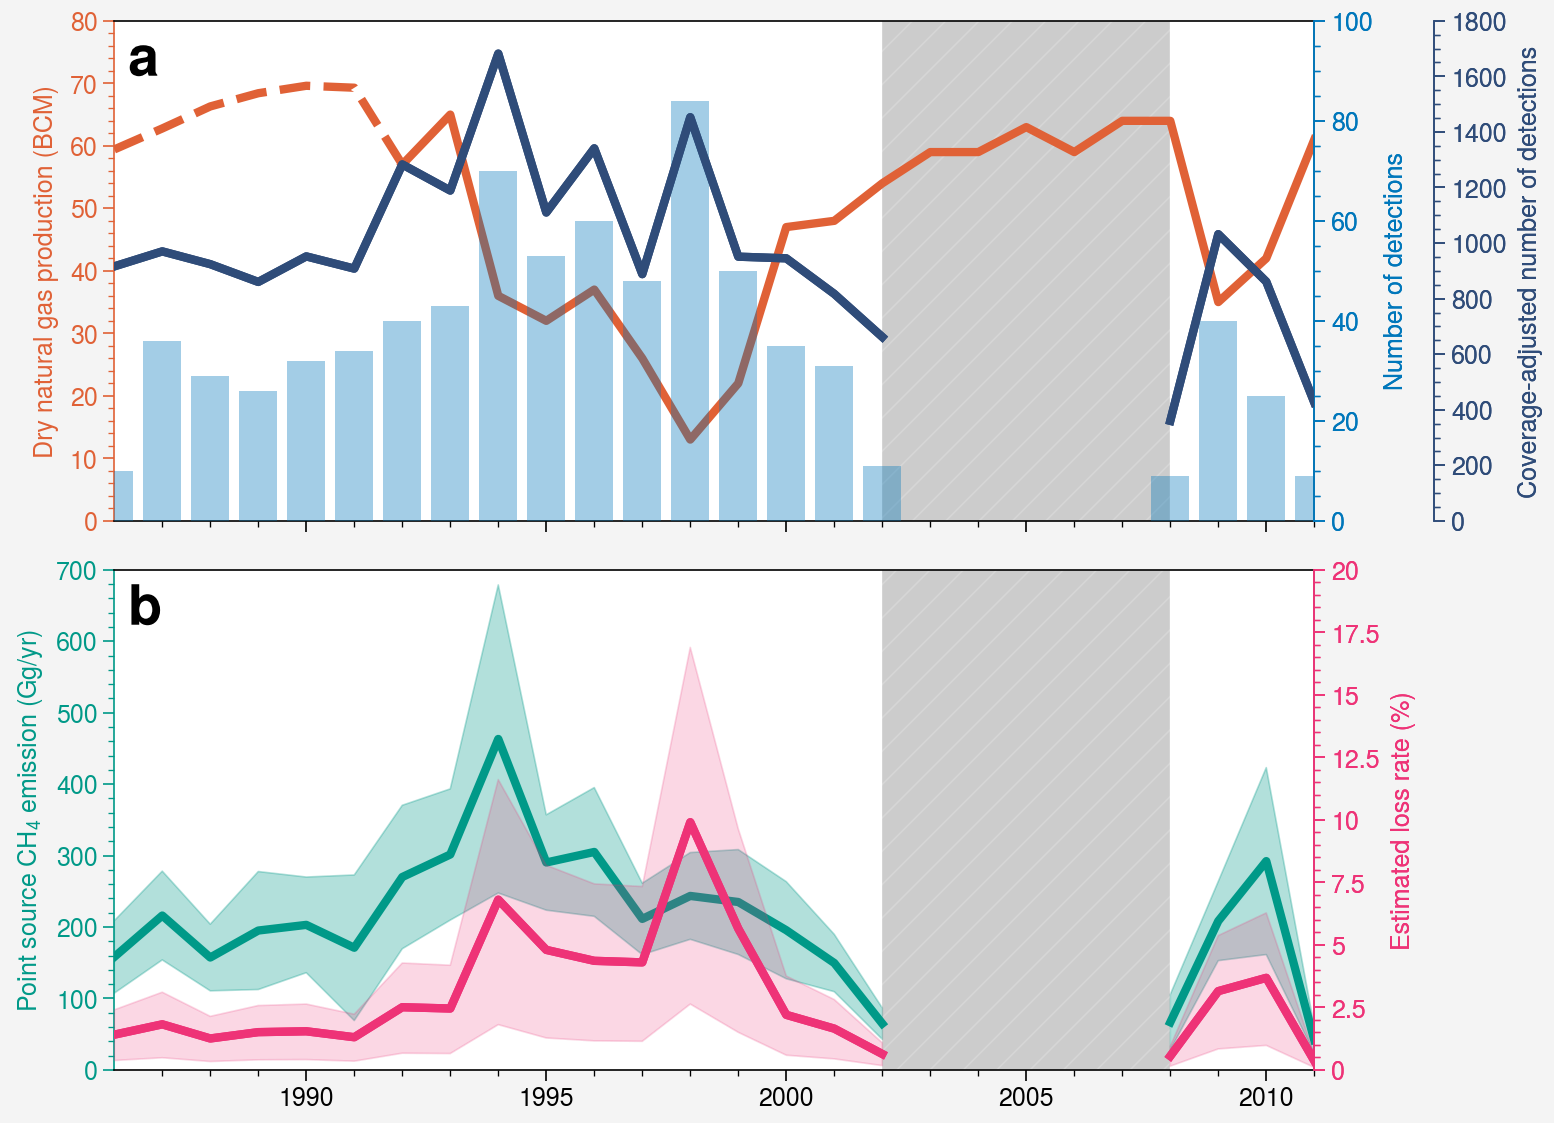

In [10]:
###### combdf = pd.read_csv('combined_data_set.csv')
year_list = list(np.concatenate([np.arange(1986, 2003), np.arange(2008, 2012)]))

f, axs = pplt.subplots(nrows=2, ncols=1, refwidth=6, refheight=2.5, sharex=True, sharey=False)
figyears = combdf['Year'].values.astype(float)
# bu_turk = combdf['EDGAR O&G Turkmenistan (Gg/yr)'].values
production_ext = combdf['Dry gas production w/ pre-1992 (Gg/yr)'].values
production_bcm = combdf['Dry gas production w/ pre-1992 (BCM)'].values
numlist = combdf['Num of detections'].values
cloud_corr = combdf['Coverage-adjusted'].values
qlist = combdf['Annual emissions (Gg/yr)'].values
eqlist = combdf['Annual emissions uncertainty (Gg/yr)'].values
leakrate = combdf['Leak rate (%)'].values

axs[0].axvspan(2002, 2008, facecolor='black', hatch='//', edgecolor='white', alpha=0.2)
axs[1].axvspan(2002, 2008, facecolor='black', hatch='//', edgecolor='white', alpha=0.2)
axs[0].plot(figyears[6:], production_bcm[6:], lw=3, color='#E06136', ls='-')
axs[0].plot(figyears[:7], production_bcm[:7], lw=3, color='#E06136', ls='--')
axs[0].format(ylim=(0, 80), ycolor='#E06136', ylabel='Dry natural gas production (BCM)')


axstemp = axs[0].twinx(yloc=('axes', 1), color='#0077BB')
axstemp.set_xlim((1985, 2012))
axstemp.bar(figyears, numlist, color='#0077BB', alpha=0.2)
axstemp.format(ylabel='Number of detections', ycolor='#0077BB', alpha=0.2, ylim=(0, 100))


axstemp = axs[0].twinx(yloc=('axes', 1.1), color='#2F4C79', label='Coverage-adjusted number of detections')
axstemp.plot(figyears, cloud_corr, lw=3, color='#2F4C79', ls='-')
# axstemp.plot(year_list[-4:], cloud_corr[-4:], lw=3, color='#2F4C79', ls='-')
axstemp.format(ylim=(0, 1800))


axs[1].plot(figyears, qlist, lw=3, color='#009988', ls='-')
axs[1].fill_between(figyears, qlist-eqlist, qlist+eqlist, color='#009988', alpha=0.3)
axs[1].format(ylabel=r'Point source CH$_4$ emission (Gg/yr)', ycolor='#009988', ylim=(0, 700))


axstemp = axs[1].twinx(yloc=('axes', 1), color='#EE3377', alpha=0.6, label='Estimated loss rate (%)')
scale = np.nanmax(bu_turk[:16]/qlist[:16])
scale2 = np.nanmean(bu_turk[:16]/qlist[:16])
upperleak = scale*leakrate
optleak = scale2*leakrate
combdf['Upper bound leak rate (%)'] = upperleak
combdf['Optimal leak rate (%)'] = optleak
combdf.to_csv('combined_data_set.csv', index=False)

axstemp.fill_between(figyears, leakrate, leakrate*scale, color='#EE3377', alpha=0.1)
axstemp.plot(figyears, leakrate*scale2, lw=3, color='#EE3377', ls='-')
# axstemp.format(xlocator=[1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020], 
#               xminorlocator=1,
#               ycolor='#EE3377')

# axstemp = axs[1].twinx(yloc=('axes', 1.1), color='k', alpha=0.4, label='fSU O&G CH$_4$ emission (Gg)')
# axstemp.plot(range(1970, 2019), bu_fsu, lw=3, color='k', ls='--')
axstemp.format(ylim=(0, 20))
axs.grid(False)
f.format(abc=True, abcloc='ul', abcstyle='a', abcsize=20, xlim=(1986, 2011))
# plt.savefig('fig2_Jan5.pdf')